# Notebook de Análisis de Telemetría

Este notebook guiará paso a paso el análisis de los datos de telemetría.
En cada sección pegaremos el código correspondiente y verificaremos su funcionamiento.

## 1. Preparación del entorno

In [1]:
# Importar librerías básicas
import os, glob, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ajustes de estilo de pandas
pd.set_option('display.max_columns', None)

print('Librerías importadas correctamente.')

Librerías importadas correctamente.


## 2. Carga y consolidación de datos

In [2]:
# 2. Carga y consolidación de todos los JSON de telemetría
pattern = os.path.join('data', 'telemetry_*.json')
records = []
for fn in glob.glob(pattern):
    with open(fn, 'r') as f:
        records.extend(json.load(f))

# Crear DataFrame y mostrar un vistazo
df = pd.DataFrame(records)
print(f"Eventos cargados: {len(df)}")
print("Columnas disponibles:", df.columns.tolist())
df.head()


Eventos cargados: 427
Columnas disponibles: ['eventType', 'gameID', 'playerID', 'sessionID', 'timestamp', 'levelStarted', 'bulletID', 'otherWeaponsInfo', 'posX', 'posY', 'posZ', 'weaponUsed', 'hasHitEnemy', 'hasKillEnemy']


,eventType,gameID,playerID,sessionID,timestamp,levelStarted,bulletID,otherWeaponsInfo,posX,posY,posZ,weaponUsed,hasHitEnemy,hasKillEnemy
0,GameStart,Damn,System Serial Number \n,System Serial Number \n1745360411851,1603689675,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LevelStart,Damn,System Serial Number \n,System Serial Number \n1745360411851,1603689675,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Shot,Damn,System Serial Number \n,System Serial Number \n1745360411851,1603689675,NaN,0.0,{},0.128115,3.339171,3.584145,0.0,NaN,NaN
3,ShotCollision,Damn,System Serial Number \n,System Serial Number \n1745360411851,1603689675,NaN,0.0,NaN,-2.935257,3.783961,-10.233800,NaN,False,False
4,Shot,Damn,System Serial Number \n,System Serial Number \n1745360411851,1603689675,NaN,1.0,{},-3.179706,3.322469,2.600487,0.0,NaN,NaN


In [3]:
# 2.1 Verificación de archivos y sesiones cargadas
import json

# Mostrar los ficheros detectados por glob
print("Patrón usado:", pattern)
files = glob.glob(pattern)
print("Archivos detectados:")
for f in files:
    print(" ", f)

# Contar eventos por fichero
print("\nEventos por fichero:")
for f in files:
    with open(f, 'r') as myf:
        data = json.load(myf)
    print(f"  {os.path.basename(f)}: {len(data)} eventos")

# Contar eventos por sesión en el DataFrame consolidado
print("\nEventos por SessionID en df:")
print(df['sessionID'].value_counts())


Patrón usado: data\telemetry_*.json
Archivos detectados:
  data\telemetry_1745360411.json
  data\telemetry_1745360445.json
  data\telemetry_1745360510.json
  data\telemetry_1745360758.json
  data\telemetry_1745360922.json
  data\telemetry_1745361010.json

Eventos por fichero:
  telemetry_1745360411.json: 42 eventos
  telemetry_1745360445.json: 2 eventos
  telemetry_1745360510.json: 245 eventos
  telemetry_1745360758.json: 76 eventos
  telemetry_1745360922.json: 60 eventos
  telemetry_1745361010.json: 2 eventos

Eventos por SessionID en df:
sessionID
System Serial Number  \n1745360510563    245
System Serial Number  \n1745360758676     76
System Serial Number  \n1745360922787     60
System Serial Number  \n1745360411851     42
System Serial Number  \n1745360445810      2
System Serial Number  \n1745361010743      2
Name: count, dtype: int64


## 3. Normalización de columnas


In [4]:
# 3. Renombrar columnas para un esquema claro
df.rename(columns={
    'eventType':    'EventType',
    'gameID':       'GameID',
    'playerID':     'PlayerID',
    'sessionID':    'SessionID',
    'timestamp':    'Timestamp',
    'levelStarted': 'LevelStarted',
    'bulletID':     'BulletID',
    'otherWeaponsInfo': 'AmmoState',
    'posX':         'PosX',
    'posY':         'PosY',
    'posZ':         'PosZ',
    'weaponUsed':   'Weapon',
    'hasHitEnemy':  'HasHitEnemy',
    'hasKillEnemy': 'HasKillEnemy'
}, inplace=True)

# Comprobar que todo está renombrado
print(df.columns.tolist())


['EventType', 'GameID', 'PlayerID', 'SessionID', 'Timestamp', 'LevelStarted', 'BulletID', 'AmmoState', 'PosX', 'PosY', 'PosZ', 'Weapon', 'HasHitEnemy', 'HasKillEnemy']


## 4. Preprocesado de disparos y colisiones


In [5]:
# 4. Filtrar eventos Shot y ShotCollision y preparar para unirlos

# Eventos de disparo
shots = df[df.EventType == 'Shot'][[
    'SessionID', 'BulletID', 'Weapon', 'AmmoState',
    'PosX', 'PosY', 'PosZ', 'Timestamp'
]].copy()

# Eventos de colisión (muerte de bala)
coll = df[df.EventType == 'ShotCollision'][[
    'SessionID', 'BulletID', 'HasHitEnemy', 'HasKillEnemy',
    'PosX', 'PosY', 'PosZ', 'Timestamp'
]].copy()

# Renombrar columnas para el merge
shots.rename(columns={
    'PosX': 'x_shot', 'PosY': 'y_shot', 'PosZ': 'z_shot',
    'Timestamp': 't_shot'
}, inplace=True)
coll.rename(columns={
    'PosX': 'x_coll', 'PosY': 'y_coll', 'PosZ': 'z_coll',
    'Timestamp': 't_coll'
}, inplace=True)

# Mostrar conteos iniciales
print(f"Disparos (shots): {len(shots)}")
print(f"Colisiones (collisions): {len(coll)}")


Disparos (shots): 179
Colisiones (collisions): 220


## 5. Unión y cálculo de distancia


In [6]:
# 5. Merge de shots y coll en un solo DataFrame
merged = pd.merge(
    shots,
    coll,
    on=['SessionID','BulletID'],
    how='inner'
)
print(f"Registros tras merge: {len(merged)}")

# 5.2 Calcular distancia euclídea
merged['Distance'] = np.sqrt(
    (merged['x_coll'] - merged['x_shot'])**2 +
    (merged['y_coll'] - merged['y_shot'])**2 +
    (merged['z_coll'] - merged['z_shot'])**2
)

# 5.3 Categorizar en corta, media, larga, fuera
bins = [0, 12, 25, 60, np.inf]
labels = ['corta','media','larga','fuera']
merged['DistCategory'] = pd.cut(merged['Distance'], bins=bins, labels=labels)

# Mostrar un ejemplo
print(merged[['SessionID','Weapon','DistCategory','Distance','HasHitEnemy']].head(10))


Registros tras merge: 420
                               SessionID  Weapon DistCategory    Distance  \
0  System Serial Number  \n1745360411851     0.0        media   14.160426   
1  System Serial Number  \n1745360411851     0.0        corta    5.388403   
2  System Serial Number  \n1745360411851     0.0        media   12.303447   
3  System Serial Number  \n1745360411851     0.0        fuera  200.061952   
4  System Serial Number  \n1745360411851     0.0        media   12.889200   
5  System Serial Number  \n1745360411851     0.0        media   19.638108   
6  System Serial Number  \n1745360411851     0.0        corta    4.085568   
7  System Serial Number  \n1745360411851     0.0        corta   11.463604   
8  System Serial Number  \n1745360411851     0.0        corta    9.382070   
9  System Serial Number  \n1745360411851     0.0        corta    9.937768   

  HasHitEnemy  
0       False  
1       False  
2       False  
3       False  
4       False  
5       False  
6       False 

## 6. Métrica 1: Hit Rate por arma y distancia (todas las sesiones)

Aquí no filtramos por munición alternativa (no hay datos fiables en AmmoState), así que usamos **todos** los registros emparejados.



C:\Users\javim\AppData\Local\Temp\ipykernel_24916\2523550083.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['SessionID','Weapon','DistCategory'])


                                SessionID  Weapon DistCategory   HitRate
0   System Serial Number  \n1745360411851     0.0        corta       0.7
1   System Serial Number  \n1745360411851     0.0        media  0.285714
2   System Serial Number  \n1745360411851     0.0        larga       0.0
3   System Serial Number  \n1745360411851     0.0        fuera       0.0
4   System Serial Number  \n1745360411851     1.0        corta       NaN
5   System Serial Number  \n1745360411851     1.0        media       NaN
6   System Serial Number  \n1745360411851     1.0        larga       NaN
7   System Serial Number  \n1745360411851     1.0        fuera       NaN
8   System Serial Number  \n1745360411851     2.0        corta       NaN
9   System Serial Number  \n1745360411851     2.0        media       NaN
10  System Serial Number  \n1745360411851     2.0        larga       NaN
11  System Serial Number  \n1745360411851     2.0        fuera       NaN


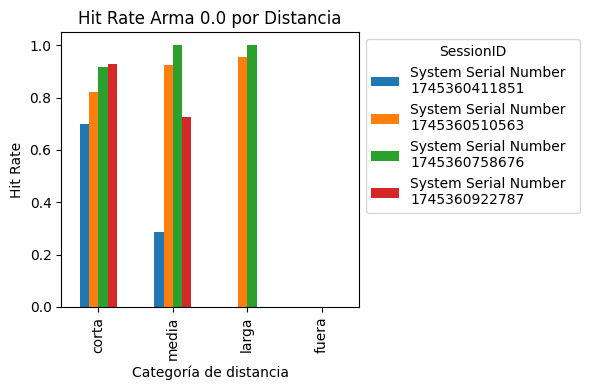

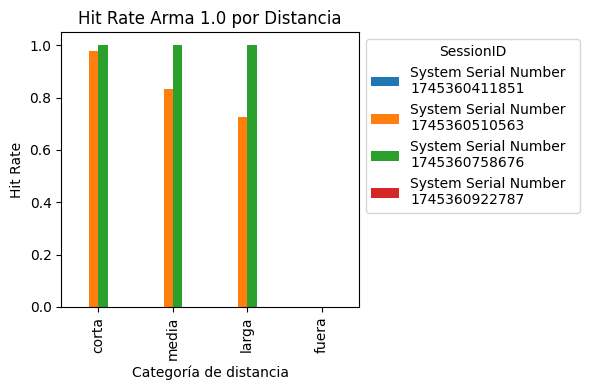

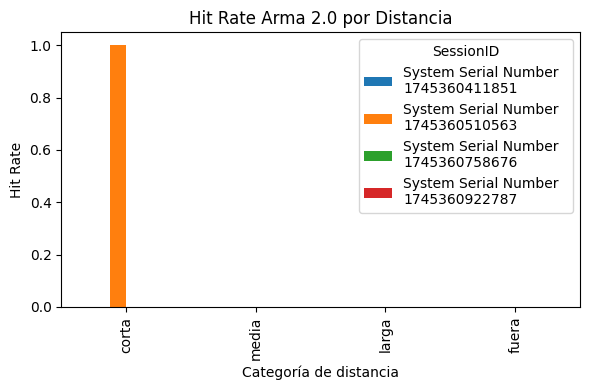

In [8]:
# 6.1 Calcular hit rate por SessionID, Weapon y DistCategory sobre 'merged'
stats1 = (
    merged
    .groupby(['SessionID','Weapon','DistCategory'])
    .HasHitEnemy
    .mean()
    .reset_index(name='HitRate')
)

# Mostrar tabla de ejemplo
print(stats1.head(12))

# 6.2 Graficar un bar plot para cada arma
for w in sorted(stats1.Weapon.unique()):
    dfw = stats1[stats1.Weapon==w]
    pivot = dfw.pivot(index='DistCategory', columns='SessionID', values='HitRate')
    ax = pivot.plot(kind='bar', figsize=(6,4), title=f'Hit Rate Arma {w} por Distancia')
    ax.set_xlabel('Categoría de distancia')
    ax.set_ylabel('Hit Rate')
    ax.legend(title='SessionID', bbox_to_anchor=(1,1))
    plt.tight_layout()
    plt.show()


## 7. Uso de escopeta (weapon=1) y rifle (weapon=2) por nivel (2 y 3)

En este apartado:

1. **7.1** Extraemos todos los eventos de disparo (`Shot`).  
2. **7.2** Extraemos los eventos de inicio de nivel (`LevelStart`).  
3. **7.3** Asociamos cada disparo con el nivel en el que ocurrió, usando `merge_asof` por timestamp.  
4. **7.4** Filtramos sólo los disparos de los niveles 2 y 3.  
5. **7.5** Calculamos el porcentaje de disparos por arma (0=pistola, 1=escopeta, 2=rifle) en cada sesión y nivel.  
6. **7.6** Mostramos un pequeño extracto de la tabla resultante.  
7. **7.7** Dibujamos dos gráficas (una para el nivel 2 y otra para el nivel 3), donde cada línea es una sesión distinta y el eje Y muestra el porcentaje de disparos.

---

                               SessionID Weapon       Pct  Level
0  System Serial Number  \n1745360510563    0.0  0.811881      2
1  System Serial Number  \n1745360510563    1.0  0.168317      2
2  System Serial Number  \n1745360510563    2.0  0.019802      2


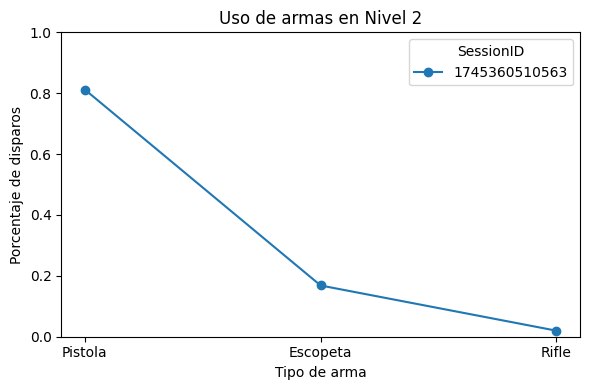

C:\Users\javim\AppData\Local\Temp\ipykernel_24916\247346085.py:77: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title='SessionID')


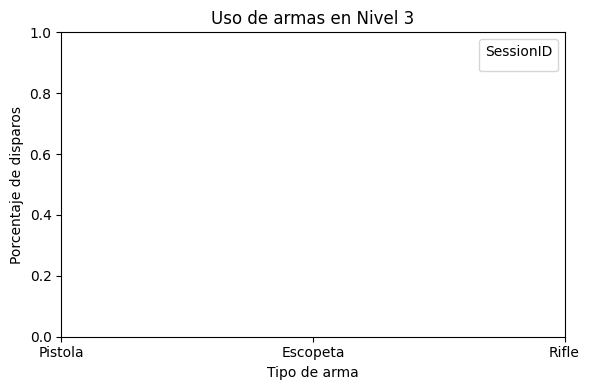

In [12]:

import pandas as pd
import matplotlib.pyplot as plt

# 7.1 – Extraer solo los disparos
shots_all = (
    df[df['EventType']=='Shot']
      [['SessionID','Timestamp','Weapon']]
      .copy()
)

# 7.2 – Extraer los inicios de nivel
levels = (
    df[df['EventType']=='LevelStart']
      [['SessionID','Timestamp','LevelStarted']]
      .rename(columns={
          'Timestamp': 't_level',
          'LevelStarted': 'Level'
      })
)

# 7.3 – Asignar nivel a cada disparo (merge_asof)
shots_all = shots_all.sort_values('Timestamp')
levels   = levels.sort_values('t_level')
shots_all = pd.merge_asof(
    left=shots_all,
    right=levels,
    left_on='Timestamp',
    right_on='t_level',
    by='SessionID',
    direction='backward'
)

# 7.4 – Filtrar solo niveles 2 y 3
shots_l2 = shots_all[shots_all['Level']==2]
shots_l3 = shots_all[shots_all['Level']==3]

# 7.5 – Función para calcular % de disparos por arma en cada sesión⋅nivel
def usage_percent(shots_df, level):
    cnt   = shots_df.groupby(['SessionID','Weapon']).size().unstack(fill_value=0)
    total = cnt.sum(axis=1)
    pct   = cnt.div(total, axis=0)
    df_pct = pct.reset_index().melt(
        id_vars   = 'SessionID',
        var_name  = 'Weapon',
        value_name= 'Pct'
    )
    df_pct['Level'] = level
    return df_pct

u2 = usage_percent(shots_l2, 2)
u3 = usage_percent(shots_l3, 3)
usage = pd.concat([u2, u3], ignore_index=True)

# 7.6 – Rápido vistazo a los datos
print(usage.sort_values(['Level','SessionID','Weapon']).head(10))

# 7.7 – Dibujar gráficas por nivel
weapon_names = {0:'Pistola', 1:'Escopeta', 2:'Rifle'}

for lvl in [2,3]:
    fig, ax = plt.subplots(figsize=(6,4))
    sub = usage[usage['Level']==lvl]
    for sid in sub['SessionID'].unique():
        tmp = sub[sub['SessionID']==sid]
        ax.plot(
            tmp['Weapon'],
            tmp['Pct'],
            marker='o',
            label=sid.split()[-1]   # solo la parte final de SessionID
        )
    ax.set_xticks([0,1,2])
    ax.set_xticklabels([weapon_names[w] for w in [0,1,2]])
    ax.set_ylim(0,1)
    ax.set_xlabel('Tipo de arma')
    ax.set_ylabel('Porcentaje de disparos')
    ax.set_title(f'Uso de armas en Nivel {lvl}')
    ax.legend(title='SessionID')
    plt.tight_layout()
    plt.show()
